<a href="https://colab.research.google.com/github/NikitaNefedov007/AiPPojectMozhno4Pochaluyasta/blob/main/LAB7_Ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving img.jpg to img.jpg
Saving img_style.jpg to img_style.jpg


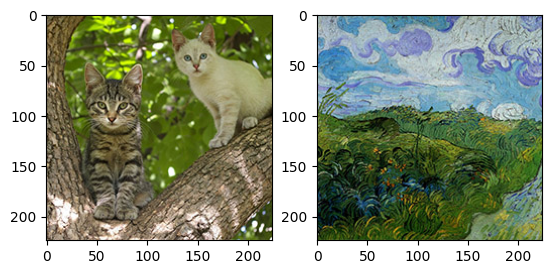

80134624/80134624 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

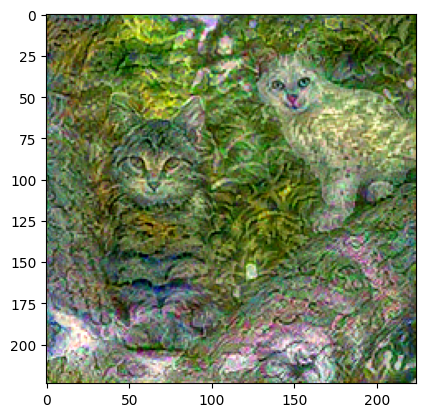

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow import keras


upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0)) # реализуес VGG19 (RGB->BGR)

def deprocess_img(processed_img): # обратная функция BGR->RGB
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0) # Убирае 0 ось
  assert len(x.shape) == 3, ("IВходными данными для обработки изображения должно быть изображение размера "
                             " [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # выполним операцию, обратную шагу предварительной обработки
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8') # отбрасываем
  return x

vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Слой содержимого, на котором будут отображаться наши карты объектов
content_layers = ['block5_conv2']

# Слой стиля, который нас интересует
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs # объединяем выходы

print(vgg.input)
for m in model_outputs:
  print(m)

model = keras.models.Model(vgg.input, model_outputs) # строится модель VGG зная Input Output
for layer in model.layers:
    layer.trainable = False

print(model.summary())      # вывод структуры НС в консоль

def get_feature_representations(model): #карта признаков для стиля и для контента
  style_outputs = model(x_style)
  content_outputs = model(x_img)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features



def get_content_loss(base_content, target): # Потери контента
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):  #Работаем с каналами
  # Создаем каналы изображения
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels]) # преобразуем в 2-мерный
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32) # Усредняем

def get_style_loss(base_style, gram_target): # Потери стиля
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features): #Общая фун-ция потерь
  style_weight, content_weight = loss_weights

  model_outputs = model(init_image) #Значение на каждом сверточном слое

  style_output_features = model_outputs[:num_style_layers] # карта признаков стиля
  content_output_features = model_outputs[num_style_layers:] # карта признаков контента

  style_score = 0
  content_score = 0
  weight_per_style_layer = 1.0 / float(num_style_layers) # Веса для суммирования слоя стиля
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Накапливать потери содержимого со всех слоев
  weight_per_content_layer = 1.0 / float(num_content_layers)  # Тоже самое для контент слоя
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight


  loss = style_score + content_score   #Общий критерий качества
  return loss, style_score, content_score

num_iterations=100 #Число итераций
content_weight=1e3 #Насколько важен контент (Альфа)
style_weight=1e-2 #Насколько важен стиль (Бэта)

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features] #считаем матрицу сразу

init_image = np.copy(x_img) # начальное изображение
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1) #Оптимизаторы для градиентного спуска
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = { #Словарь для простоты использования
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape:
       all_loss = compute_loss(**cfg)

    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image) # вычисляем градиент

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)

    if loss < best_loss:
      # Обновите лучшие потери и лучшее изображение из total loss.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Используйте метод .numpy()
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))

plt.imshow(best_img)
print(best_loss)

image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")